In [2]:
library("randomForestSRC")
library(qiime2R)
library(tidyr)
library(tibble)
library(ggplot2)
library(microbiome)
library(phyloseq)
library("tidyverse")
library("dplyr")
#Load libraries
library(vegan)
library(dplyr)
library(magrittr)
library(scales)
library(grid)
library(reshape2)
library(knitr)
library(shapr)


 randomForestSRC 3.3.3 
 
 Type rfsrc.news() to see new features, changes, and bug fixes. 
 


Loading required package: phyloseq


microbiome R package (microbiome.github.com)
    


 Copyright (C) 2011-2022 Leo Lahti, 
    Sudarshan Shetty et al. <microbiome.github.io>



Attaching package: ‘microbiome’


The following object is masked from ‘package:ggplot2’:

    alpha


The following object is masked from ‘package:base’:

    transform


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ purrr     1.0.4
✔ forcats   1.0.0     ✔ readr     2.1.5
✔ lubridate 1.9.4     ✔ stringr   1.5.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ microbiome::alpha() masks ggplot2::alpha()
✖ dplyr::filter()     masks stats::filter()
✖ dplyr::lag()        masks stats::lag()
✖ purrr::partial()    masks randomForestSRC::partial()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts t

In [3]:
# Read in the 16S qza files and clean them up for phyloseq
ASVs <- read_qza("/Users/stephanie.rosales/Documents/omics_projects/Resitada/qiime_output/table-BacArc_resistada.qza")
ASVs <- ASVs$data # Extract the count data from list


tree_file <-read_qza("/Users/stephanie.rosales/Documents/omics_projects/Resitada/qiime_output/rooted-BacArc_resistada.qza")$data


taxa_16S <- read_qza("/Users/stephanie.rosales/Documents/omics_projects/Resitada/qiime_output/taxonomy_resistada.qza")
taxa_16S <- taxa_16S$data %>% as_tibble() %>% separate(Taxon, sep=";",
c("Kingdom", "Phylum", "Class", "Order", "Family", "Genus", "Species")) %>% 
# Convert taxonomy info to data frame with correct taxonomy labels
#taxa <- taxa_16S[-1,]
select(-Confidence) %>% arrange(Feature.ID) %>% mutate(ASV = 1:n()) %>% 
mutate(newcol = "ASV") %>%
unite("ASVs", newcol:ASV) %>%
filter(Phylum !=" p__Chlorophyta") %>%
filter(Phylum !="NA")

Warning message:
“Expected 7 pieces. Missing pieces filled with `NA` in 5374 rows [3, 6, 9, 11,
12, 14, 15, 16, 17, 18, 22, 23, 27, 31, 36, 38, 42, 45, 49, 51, ...].”


In [4]:
meta = read.csv("/Users/stephanie.rosales/Documents/omics_projects/Resitada/metadata_RESISTADA.csv", 
                header = T, row.names = 1,
na.strings = c("", "NA"))


meta$Genotype = factor(meta$Genotype, levels = c("FM19", 
                                                                
                                        "FM6", "FM9", "U44",
                                        "FM14", "Elkhorn", "K2",
                                        "Acerv2", "Kelsey-1", "Cooper-9", "U41"
                                                                ))

In [5]:
ps= phyloseq(otu_table(ASVs, taxa_are_rows= T),
tax_table(as.data.frame(taxa_16S) %>% column_to_rownames("Feature.ID") %>%
as.matrix()), sample_data(meta), tree_file)
ps

dups = c("N169_256_R2", "N157_265_R2", "N165_296_R2", "N161_A067_R2", "N185_A088_R2",
                                 "N164_A089_R2","N119_A107","N267_A110","N7_A114", "N156_A115","N158_A116",
                                 "N101_A118","N160_A119","N277_A125")

ps = subset_samples(ps, !ID %in% dups & Genotype!=c("U41"))
                                                    #,"U44")) 
ps

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 9492 taxa and 280 samples ]
sample_data() Sample Data:       [ 280 samples by 58 sample variables ]
tax_table()   Taxonomy Table:    [ 9492 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 9492 tips and 8365 internal nodes ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 9492 taxa and 252 samples ]
sample_data() Sample Data:       [ 252 samples by 58 sample variables ]
tax_table()   Taxonomy Table:    [ 9492 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 9492 tips and 8365 internal nodes ]

In [8]:
ps_Clipped =subset_samples(ps, Type=="Clipped")
ps_Clipped


ps_paired = subset_samples(ps_Clipped, Pairs=="paired")
ps_paired


select=c("Ambient_Pathogen", "NH4_Pathogen", "Ambient_Placebo")
ps_disease =subset_samples(ps_paired, select %in% Combo)
ps_disease

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 9492 taxa and 192 samples ]
sample_data() Sample Data:       [ 192 samples by 58 sample variables ]
tax_table()   Taxonomy Table:    [ 9492 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 9492 tips and 8365 internal nodes ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 9492 taxa and 135 samples ]
sample_data() Sample Data:       [ 135 samples by 58 sample variables ]
tax_table()   Taxonomy Table:    [ 9492 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 9492 tips and 8365 internal nodes ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 9492 taxa and 135 samples ]
sample_data() Sample Data:       [ 135 samples by 58 sample variables ]
tax_table()   Taxonomy Table:    [ 9492 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 9492 tips and 8365 internal nodes ]

In [9]:
sample_data(ps_disease) %>%
  group_by(Combo, Health) %>%
  summarize(Paired = n())

`summarise()` has grouped output by 'Combo'. You can override using the
`.groups` argument.


Combo,Health,Paired
<chr>,<chr>,<int>
Ambient_Pathogen,AH,3
Ambient_Pathogen,DL,23
Ambient_Placebo,AH,36
NH4_Pathogen,AH,2
NH4_Pathogen,DL,30
NH4_Placebo,AH,36
NH4_Placebo,DL,5


In [10]:
ps_fill_clip = filter_taxa(ps_Clipped, function(x) sum(x > 5) > (0.01*length(x)), TRUE)
ps_fill_clip

ps_clr_clip <- microbiome::transform(ps_fill_clip, 'clr')
                           

ps_fill_pair = filter_taxa(ps_paired, function(x) sum(x > 10) > (0.015*length(x)), TRUE)
ps_fill_pair  


ps_fill_disease = filter_taxa(ps_disease, function(x) sum(x > 5) > (0.05*length(x)), TRUE)
ps_fill_disease                            

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 1845 taxa and 192 samples ]
sample_data() Sample Data:       [ 192 samples by 58 sample variables ]
tax_table()   Taxonomy Table:    [ 1845 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 1845 tips and 1561 internal nodes ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 869 taxa and 135 samples ]
sample_data() Sample Data:       [ 135 samples by 58 sample variables ]
tax_table()   Taxonomy Table:    [ 869 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 869 tips and 729 internal nodes ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 300 taxa and 135 samples ]
sample_data() Sample Data:       [ 135 samples by 58 sample variables ]
tax_table()   Taxonomy Table:    [ 300 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 300 tips and 250 internal nodes ]

In [11]:
# Make a dataframe of training data with OTUs as column and samples as rows
predictors <- t(otu_table(ps_fill_disease))
dim(predictors)

[1] 135 300

In [12]:
# Load necessary libraries
library("tableone")
library("DALEX")
library("ggplot2")
library("partykit")
library("mlr3")
library("mlr3learners")
library("ranger")
library("mlr3tuning")
library("paradox")

Welcome to DALEX (version: 2.4.3).
Find examples and detailed introduction at: http://ema.drwhy.ai/



Attaching package: ‘DALEX’


The following object is masked from ‘package:shapr’:

    explain


The following object is masked from ‘package:dplyr’:

    explain


Loading required package: libcoin

Loading required package: mvtnorm

Loading required package: paradox


Attaching package: ‘mlr3tuning’


The following object is masked from ‘package:randomForestSRC’:

    tune




Preparation of a new explainer is initiated
  -> model label       :  Ranger 
  -> data              :  135  rows  300  cols 
  -> target variable   :  135  values 
  -> predict function  :  predict_function 
  -> predicted values  :  No value for predict function target column. (  default  )
  -> model_info        :  package Model of class: LearnerClassifRanger package unrecognized , ver. Unknown , task regression (  default  ) 
  -> predicted values  :  numerical, min =  0 , mean =  0.4071274 , max =  0.9991111  
  -> residual function :  difference between y and yhat (  default  )
  -> residuals         :  numerical, min =  -0.5255794 , mean =  0.007687419 , max =  0.5286944  
  A new explainer has been created!  


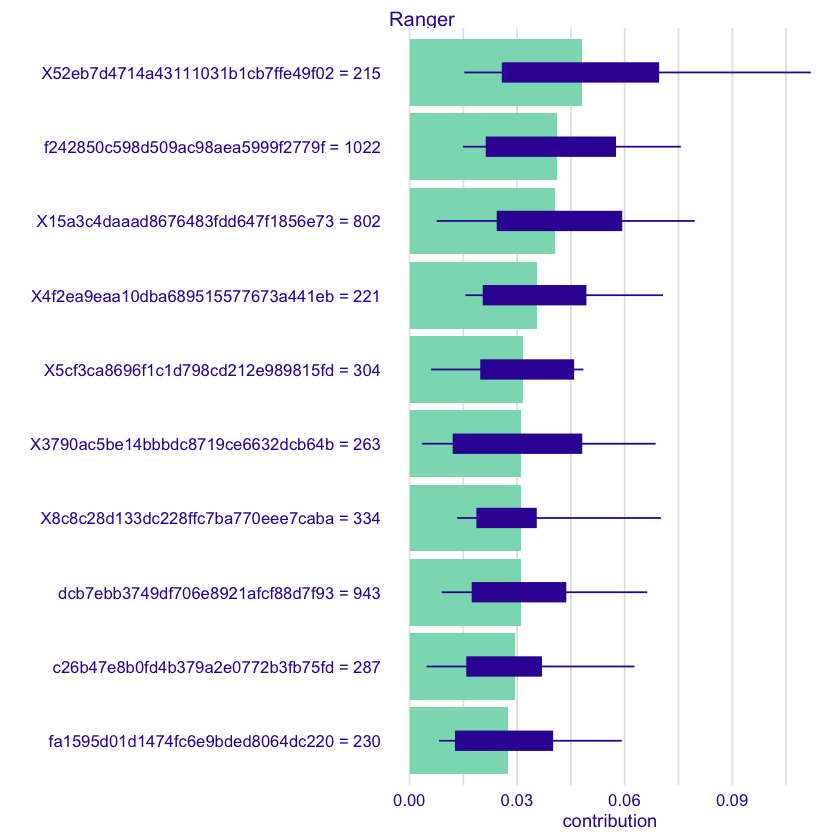

In [13]:
library(mlr3)
library(mlr3learners)
library(DALEX)
library(iBreakDown)

# Prepare data
predictors <- t(otu_table(ps_fill_disease))
response <- as.factor(sample_data(ps_fill_disease )$Survivorship)
rf.data <- data.frame(response, predictors)
rf.data <- rf.data[!is.na(rf.data$response), ]

# Create task and train
task <- TaskClassif$new(id = "Surv", backend = rf.data, target = "response", positive = "1")
learner <- lrn("classif.ranger", predict_type = "prob", num.trees = 300)
learner$train(task)

# Define correct predict_function
predict_function <- function(model, newdata) {
  p <- model$predict_newdata(newdata)
  prob <- as.data.frame(p$prob)[, "1"]
  names(prob) <- rownames(newdata)
  return(prob)
}

# Create explainer
explainer <- DALEX::explain(
  model = learner,
  data = rf.data[, -1],
  y = as.numeric(rf.data$response == "1"),
  predict_function = predict_function,
  label = "Ranger"
)

# SHAP for one observation
shap <- predict_parts(
  explainer = explainer,
  new_observation = rf.data[1, -1, drop = FALSE],
  type = "shap"
)

# Plot SHAP
plot(shap)



In [14]:
# STEP 1: Convert SHAP results to data frame
shap_df <- as.data.frame(shap)

# STEP 2: Create and clean variable_name from 'variable' column
shap_df$variable_name <- gsub(" = .*", "", shap_df$variable)                     # Remove '= value'
shap_df$variable_name <- gsub("X", "", shap_df$variable_name)                   # Remove leading 'X' from numeric feature names (if needed)
shap_df$variable_name <- tolower(shap_df$variable_name)                         # Optional: lowercase for consistency

# STEP 3: Prepare taxonomy table
taxonomy_df <- as.data.frame(tax_table(ps_fill_pair))
taxonomy_df$variable_name <- rownames(taxonomy_df)
taxonomy_df$variable_name <- gsub("^X", "", taxonomy_df$variable_name)          # Remove leading X if present in rownames
taxonomy_df$variable_name <- tolower(taxonomy_df$variable_name)                # Optional

# STEP 4: Merge SHAP results with taxonomy info
merged_data <- dplyr::inner_join(shap_df, taxonomy_df, by = "variable_name")

# STEP 5: Inspect result
head(merged_data)
dim(merged_data)


,variable,contribution,variable_name,variable_value,sign,label,B,Kingdom,Phylum,Class,Order,Family,Genus,Species,ASVs
,<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,a0fc8d8c3c84ed90adfdb3c3828a3341 = 0,3.409877e-05,a0fc8d8c3c84ed90adfdb3c3828a3341,0,1,Ranger,0,d__Bacteria,p__Verrucomicrobiota,c__Verrucomicrobiae,o__Verrucomicrobiales,f__Rubritaleaceae,g__Rubritalea,s__Rubritalea_tangerina,ASV_6413
2,a14b7162edeb7a30ddb2a46656539857 = 0,-2.498765e-05,a14b7162edeb7a30ddb2a46656539857,0,-1,Ranger,0,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rhodobacterales,f__Rhodobacteraceae,NA,NA,ASV_6427
3,a375bcfe89e6846168661528279a2e38 = 0,-6.927102e-05,a375bcfe89e6846168661528279a2e38,0,-1,Ranger,0,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rhodobacterales,f__Rhodobacteraceae,NA,NA,ASV_6507
4,a3c29bcb6997cfe572a474e58291af1d = 0,8.077284e-04,a3c29bcb6997cfe572a474e58291af1d,0,1,Ranger,0,d__Bacteria,p__Spirochaetota,c__Spirochaetia,o__Spirochaetales,f__Spirochaetaceae,g__Spirochaeta_2,NA,ASV_6512
5,a3fbbac5fc06325d6d2d662fb9b47510 = 0,-3.559396e-05,a3fbbac5fc06325d6d2d662fb9b47510,0,-1,Ranger,0,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rickettsiales,f__Fokiniaceae,g__MD3-55,NA,ASV_6526
6,a584be7205469e63bb117d2b4992d0de = 0,6.913580e-05,a584be7205469e63bb117d2b4992d0de,0,1,Ranger,0,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rhodobacterales,f__Rhodobacteraceae,NA,NA,ASV_6573


[1] 7800   15

## Test model

In [15]:
# Define the resampling strategy (5-fold cross-validation)
resampling <- rsmp("cv", folds = 5)

# Perform the cross-validation
rr <- resample(task = task, learner = learner, resampling = resampling, store_models = TRUE)

# Check the performance metrics
rr$aggregate(msr("classif.auc"))  # You can change to another performance measure like accuracy, precision, etc.


INFO  [14:18:50.366] [mlr3] Applying learner 'classif.ranger' on task 'Surv' (iter 1/5)
INFO  [14:18:50.415] [mlr3] Applying learner 'classif.ranger' on task 'Surv' (iter 2/5)
INFO  [14:18:50.449] [mlr3] Applying learner 'classif.ranger' on task 'Surv' (iter 3/5)
INFO  [14:18:50.482] [mlr3] Applying learner 'classif.ranger' on task 'Surv' (iter 4/5)
INFO  [14:18:50.528] [mlr3] Applying learner 'classif.ranger' on task 'Surv' (iter 5/5)


classif.auc 
  0.9660172

In [16]:
# Accuracy
rr$aggregate(msr("classif.acc"))

# Precision
rr$aggregate(msr("classif.precision"))

# Recall
rr$aggregate(msr("classif.recall"))

classif.acc 
  0.9185185

classif.precision 
        0.9651515

classif.recall 
     0.8455128

In [121]:
#y = as.numeric(rf.data$response == "1")


In [26]:
write.table(merged_data, "/Users/stephanie.rosales/Documents/omics_projects/Resitada/ML/merged_data.txt") 

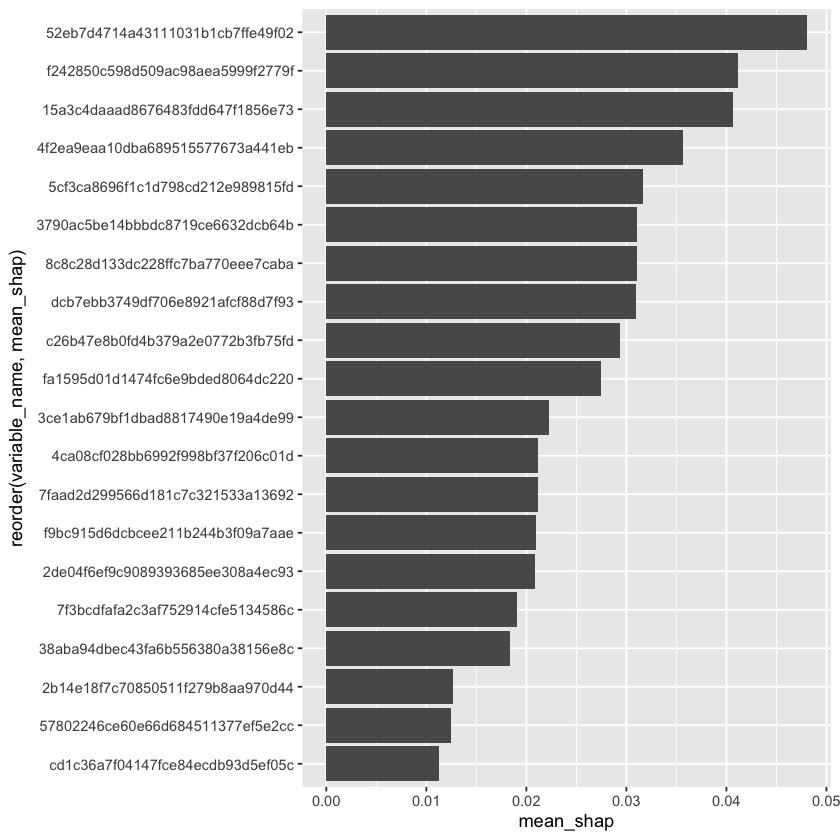

In [26]:
# Top 20 most impactful SHAP variables
top_shap <- merged_data %>%
  filter(variable_value!=0) %>%
  group_by(variable_name) %>%
  summarize(mean_shap = mean((contribution))) %>%
  arrange(desc(mean_shap)) %>%
  slice(1:20)

ggplot(top_shap, aes(x = reorder(variable_name, mean_shap), y = mean_shap)) +
  geom_col() +
  coord_flip()

In [18]:
merged_data1 <- merged_data %>%
  #filter(sign != 0) %>%  # Filter out rows where sign is 0
  group_by(variable_name) #%>%  # Group by variable_name after filtering
  #summarize(total_contribution = sum(contribution), .groups = 'drop')  # Summarize contributions


dim(merged_data1)
head(merged_data1)

[1] 7800   15

variable,contribution,variable_name,variable_value,sign,label,B,Kingdom,Phylum,Class,Order,Family,Genus,Species,ASVs
<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
a0fc8d8c3c84ed90adfdb3c3828a3341 = 0,3.409877e-05,a0fc8d8c3c84ed90adfdb3c3828a3341,0,1,Ranger,0,d__Bacteria,p__Verrucomicrobiota,c__Verrucomicrobiae,o__Verrucomicrobiales,f__Rubritaleaceae,g__Rubritalea,s__Rubritalea_tangerina,ASV_6413
a14b7162edeb7a30ddb2a46656539857 = 0,-2.498765e-05,a14b7162edeb7a30ddb2a46656539857,0,-1,Ranger,0,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rhodobacterales,f__Rhodobacteraceae,NA,NA,ASV_6427
a375bcfe89e6846168661528279a2e38 = 0,-6.927102e-05,a375bcfe89e6846168661528279a2e38,0,-1,Ranger,0,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rhodobacterales,f__Rhodobacteraceae,NA,NA,ASV_6507
a3c29bcb6997cfe572a474e58291af1d = 0,8.077284e-04,a3c29bcb6997cfe572a474e58291af1d,0,1,Ranger,0,d__Bacteria,p__Spirochaetota,c__Spirochaetia,o__Spirochaetales,f__Spirochaetaceae,g__Spirochaeta_2,NA,ASV_6512
a3fbbac5fc06325d6d2d662fb9b47510 = 0,-3.559396e-05,a3fbbac5fc06325d6d2d662fb9b47510,0,-1,Ranger,0,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rickettsiales,f__Fokiniaceae,g__MD3-55,NA,ASV_6526
a584be7205469e63bb117d2b4992d0de = 0,6.913580e-05,a584be7205469e63bb117d2b4992d0de,0,1,Ranger,0,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rhodobacterales,f__Rhodobacteraceae,NA,NA,ASV_6573


In [27]:
merged_data1

variable,contribution,variable_name,variable_value,sign,label,B,Kingdom,Phylum,Class,Order,Family,Genus,Species,ASVs
<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
a0fc8d8c3c84ed90adfdb3c3828a3341 = 0,3.409877e-05,a0fc8d8c3c84ed90adfdb3c3828a3341,0,1,Ranger,0,d__Bacteria,p__Verrucomicrobiota,c__Verrucomicrobiae,o__Verrucomicrobiales,f__Rubritaleaceae,g__Rubritalea,s__Rubritalea_tangerina,ASV_6413
a14b7162edeb7a30ddb2a46656539857 = 0,-2.498765e-05,a14b7162edeb7a30ddb2a46656539857,0,-1,Ranger,0,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rhodobacterales,f__Rhodobacteraceae,NA,NA,ASV_6427
a375bcfe89e6846168661528279a2e38 = 0,-6.927102e-05,a375bcfe89e6846168661528279a2e38,0,-1,Ranger,0,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rhodobacterales,f__Rhodobacteraceae,NA,NA,ASV_6507
a3c29bcb6997cfe572a474e58291af1d = 0,8.077284e-04,a3c29bcb6997cfe572a474e58291af1d,0,1,Ranger,0,d__Bacteria,p__Spirochaetota,c__Spirochaetia,o__Spirochaetales,f__Spirochaetaceae,g__Spirochaeta_2,NA,ASV_6512
a3fbbac5fc06325d6d2d662fb9b47510 = 0,-3.559396e-05,a3fbbac5fc06325d6d2d662fb9b47510,0,-1,Ranger,0,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rickettsiales,f__Fokiniaceae,g__MD3-55,NA,ASV_6526
a584be7205469e63bb117d2b4992d0de = 0,6.913580e-05,a584be7205469e63bb117d2b4992d0de,0,1,Ranger,0,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rhodobacterales,f__Rhodobacteraceae,NA,NA,ASV_6573
a5997412dbc7bdf31e2f533103884dbe = 75,2.782716e-04,a5997412dbc7bdf31e2f533103884dbe,75,1,Ranger,0,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rhodobacterales,f__Rhodobacteraceae,g__Shimia,NA,ASV_6577
a715a49505b6d92a11276e2b06b498ee = 0,-3.703092e-04,a715a49505b6d92a11276e2b06b498ee,0,-1,Ranger,0,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Alteromonadales,f__Colwelliaceae,g__Thalassotalea,s__Thalassotalea_ganghwensis,ASV_6632
a9753fb873feede8ae92d70ae31a7d8f = 0,-1.190672e-05,a9753fb873feede8ae92d70ae31a7d8f,0,-1,Ranger,0,d__Bacteria,p__Verrucomicrobiota,c__Verrucomicrobiae,o__Verrucomicrobiales,f__Rubritaleaceae,g__Haloferula,s__uncultured_Haloferula,ASV_6712


In [19]:
path_list = merged_data%>%
filter(variable_value != 0) %>%

#filter(contribution > -0.01 & contribution > 0.01) %>%
#filter(contribution < -0.00045 | contribution > 0.01)  %>%
arrange(-contribution) %>%
select("variable_name") %>%
distinct() %>% as.list()

path_list

$variable_name
 [1] "52eb7d4714a43111031b1cb7ffe49f02" "15a3c4daaad8676483fdd647f1856e73"
 [3] "f242850c598d509ac98aea5999f2779f" "4f2ea9eaa10dba689515577673a441eb"
 [5] "8c8c28d133dc228ffc7ba770eee7caba" "3790ac5be14bbbdc8719ce6632dcb64b"
 [7] "dcb7ebb3749df706e8921afcf88d7f93" "c26b47e8b0fd4b379a2e0772b3fb75fd"
 [9] "fa1595d01d1474fc6e9bded8064dc220" "4ca08cf028bb6992f998bf37f206c01d"
[11] "f9bc915d6dcbcee211b244b3f09a7aae" "2de04f6ef9c9089393685ee308a4ec93"
[13] "7faad2d299566d181c7c321533a13692" "5cf3ca8696f1c1d798cd212e989815fd"
[15] "38aba94dbec43fa6b556380a38156e8c" "3ce1ab679bf1dbad8817490e19a4de99"
[17] "7f3bcdfafa2c3af752914cfe5134586c" "57802246ce60e66d684511377ef5e2cc"
[19] "cd1c36a7f04147fce84ecdb93d5ef05c" "2b14e18f7c70850511f279b8aa970d44"
[21] "f3cbf8aa9b819fca152b898abba14df5" "85272a4ecdff36fe23e1b63410d73ea7"
[23] "ff3e7637bd5aac86cff3b72f9ee78f47" "abea92fec9ec149e8eb45fe902581668"
[25] "6ce7266c44dcd1d38e7ba781855515c5" "58a75ecc587c36de8b4bbbac0c6efff2"
[27] "c429cce2851f42f0d5a5f2b50fe18e33" "ca8ad3b2921bbd3cd58156a53be47677"
[29] "57cae3e69e447f81b06a7ab5275a3ea8" "761f540ee829313961a42bdce8e5f36e"
[31] "1788860a6d5db952c73537bc4f00e6ec" "e23bbf8f65f14f451c2071e477ed2b58"
[33] "615834b295798beef85aedd0dccb7cdf" "1f388d6a52fb1fe4e6010cd40d4cbda6"
[35] "8219dd81b4ec992af308733c9f3f337b" "ce80d12fb367ffe011c2fb15bf9659bc"
[37] "ea14aa41fbcf1e8af5908e975da064b8" "af9929b8c403fc72989769d9876fc007"
[39] "ac6820155a85d9cc15f8f62406e10e42" "ca5badc3404ebda2af4b9c4e61e56008"
[41] "a5997412dbc7bdf31e2f533103884dbe" "8c4250b2fdfdd56db618eac4b7569d2d"
[43] "c4067f49ab443e01537a281084d61ee8" "823c79a88cd4499479ebccd160c1d38b"
[45] "41861cce34e32070bc99d36682bf7540" "cc47dbf08e19583b226ca7aef0fdfe88"
[47] "1c74ada6c4024987db4770ba4c40f7a4" "3627a2ac2c576bfd741684742c8fd991"
[49] "9e01ef4bd4ab55dd694090fe6410edaa" "c80af310b0510a7f5cb8cabe03256301"
[51] "250667ad5482a5899713c9485d572e9c" "223b0e4c0edef256acc0cdb03c792445"

attr(,"yhats_distribution")
    variable_name variable  id  prediction  label
1        all data all data   1 0.977861111 Ranger
2        all data all data   2 0.014920635 Ranger
3        all data all data   3 0.211273810 Ranger
4        all data all data   4 0.342697090 Ranger
5        all data all data   5 0.007962963 Ranger
6        all data all data   6 0.141201058 Ranger
7        all data all data   7 0.000000000 Ranger
8        all data all data   8 0.005000000 Ranger
9        all data all data   9 0.005833333 Ranger
10       all data all data  10 0.019711640 Ranger
11       all data all data  11 0.107498677 Ranger
12       all data all data  12 0.008333333 Ranger
13       all data all data  13 0.006383598 Ranger
14       all data all data  14 0.044670635 Ranger
15       all data all data  15 0.052145503 Ranger
16       all data all data  16 0.013238095 Ranger
17       all data all data  17 0.008226190 Ranger
18       all data all data  18 0.000000000 Ranger
19       all data all data  19 0.014888889 Ranger
20       all data all data  20 0.010555556 Ranger
21       all data all data  21 0.959599206 Ranger
22       all data all data  22 0.026916667 Ranger
23       all data all data  23 0.006396825 Ranger
24       all data all data  24 0.004822751 Ranger
25       all data all data  25 0.005537037 Ranger
26       all data all data  26 0.035537037 Ranger
27       all data all data  27 0.019353175 Ranger
28       all data all data  28 0.041359788 Ranger
29       all data all data  29 0.654287037 Ranger
30       all data all data  30 0.554888889 Ranger
31       all data all data  31 0.570326720 Ranger
32       all data all data  32 0.840896825 Ranger
33       all data all data  33 0.997777778 Ranger
34       all data all data  34 0.973547619 Ranger
35       all data all data  35 0.979740741 Ranger
36       all data all data  36 0.989416667 Ranger
37       all data all data  37 0.994833333 Ranger
38       all data all data  38 0.915017196 Ranger
39       all data all data  39 0.006666667 Ranger
40    

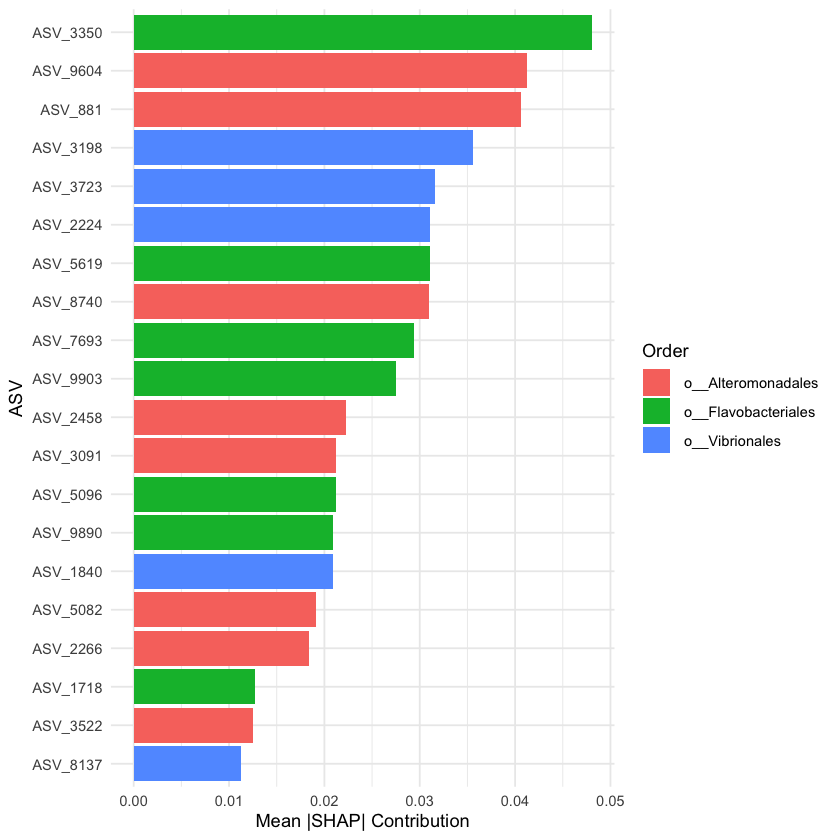

In [22]:
# Prepare top SHAP features
top_shap <- merged_data %>%
  #filter(variable_value != 0) %>%
  group_by(ASVs, Order) %>%
  summarize(mean_shap = mean(abs(contribution), na.rm = TRUE), .groups = "drop") %>%
  arrange(desc(mean_shap)) %>%
  slice(1:20)

# Plot
ggplot(top_shap, aes(x = reorder(ASVs, mean_shap), y = mean_shap, fill = Order)) +
  geom_col() +
  coord_flip() +
  labs(x = "ASV", y = "Mean |SHAP| Contribution", fill = "Order") +
  theme_minimal()


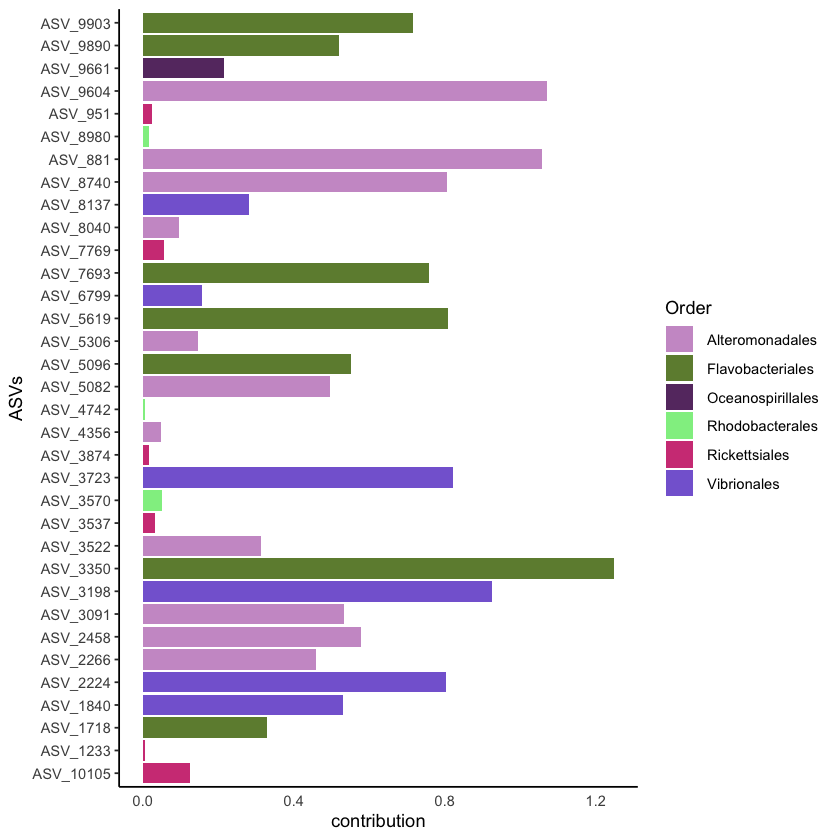

In [21]:
merged_data%>%
mutate_if(
                is.character, 
                stringr::str_replace_all, 
                pattern = "o__",
                replacement = "") %>%
filter(variable_value != 0) %>%
filter(contribution > -0.05 & contribution > 0.005) %>%
#filter(contribution < -0.00045 | contribution > 0.01)  %>%
#ggplot(aes(x = reorder(ASVs, contribution), y = contribution, fill=Order)) +
ggplot(aes(x = ASVs, y = contribution, fill=Order)) +

geom_bar(stat = "identity") +
  theme(
        axis.ticks.y=element_blank() 
        ) +
scale_fill_manual(values=c(
                           "#CD9BCD", "darkolivegreen4", "#673770", "lightgreen", "#D14285", 
                           "#8569D5", "#5E738F",
                          "red", "#CD9BCD", "gray80", "#673770", "lightgreen", "#D14285", 
                           "#8569D5", "#5E738F",
                          "red")) +
#ylab("Mortality Contribution") +
xlab("ASVs") +
  coord_flip() +
theme_classic() +
  theme(
        axis.ticks.x=element_blank() 
        ) 


#ggsave("/Users/stephanie.rosales/Documents/omics_projects/Resitada/figures/rf_contri.png", 
 #     width = 4, height = 4, units = "in", dpi=300)

In [129]:
ps= phyloseq(otu_table(ASVs, taxa_are_rows= T),
tax_table(as.data.frame(taxa_16S) %>% column_to_rownames("Feature.ID") %>%
as.matrix()), sample_data(meta), tree_file)
ps
first_hom=c("N87-Hom-D", "N87-Hom-D-R2")


ps_homgenate=subset_samples(ps, Type=="Homogenate"& sample_names %in% first_hom)
ps_homgenate

ps_homgenate = filter_taxa(ps_homgenate, function(x) sum(x > 0) > (0.0*length(x)), TRUE)
ps_homgenate 


melt_homogenate   <- ps_homgenate %>%                  
  #tax_glom(taxrank = "Family") %>%
  #transform_sample_counts(function(x) {x/sum(x)*100} ) %>% # Transform to rel. abundance
  psmelt() %>%
  distinct(OTU) %>% 
pull(OTU)

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 9492 taxa and 280 samples ]
sample_data() Sample Data:       [ 280 samples by 58 sample variables ]
tax_table()   Taxonomy Table:    [ 9492 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 9492 tips and 8365 internal nodes ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 9492 taxa and 2 samples ]
sample_data() Sample Data:       [ 2 samples by 58 sample variables ]
tax_table()   Taxonomy Table:    [ 9492 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 9492 tips and 8365 internal nodes ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 266 taxa and 2 samples ]
sample_data() Sample Data:       [ 2 samples by 58 sample variables ]
tax_table()   Taxonomy Table:    [ 266 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 266 tips and 260 internal nodes ]

In [130]:
# Subset taxa names
allTaxa_homg <- taxa_names(ps_homgenate)
allTaxa_homg <- allTaxa_homg[allTaxa_homg %in% melt_homogenate]  


In [134]:
colnames(merged_data)

[1] "variable"       "contribution"   "variable_name"  "variable_value"
 [5] "sign"           "label"          "B"              "Kingdom"       
 [9] "Phylum"         "Class"          "Order"          "Family"        
[13] "Genus"          "Species"        "ASVs"

In [137]:
path_list <- merged_data %>%
#filter(variable_value!=0) %>%
  group_by(variable_name) %>%
  summarize(mean_shap = mean(abs(contribution))) %>%
  arrange(desc(mean_shap)) %>%
  slice(1:20) %>%
  #filter(contribution < -0.05 | contribution > 0.005) %>%   # Fixed logical condition
  #arrange(desc(contribution)) %>%
  #distinct(variable_name) %>%
  pull(variable_name)   # <- returns a character vector instead of a list

# Check contents
print(path_list)

# Subset taxa names
allTaxa <- taxa_names(ps_fill_disease)
allTaxa <- allTaxa[allTaxa %in% path_list]  # Proper comparison

# Check if non-empty
if (length(allTaxa) == 0) {
  stop("No matching taxa found in phyloseq object. Check your SHAP variable names vs taxa_names().")
}

# Prune phyloseq object
sig_psr <- prune_taxa(allTaxa, ps_fill_disease)


sig_psr

allTaxa <- taxa_names(sig_psr)
allTaxa <- allTaxa[allTaxa %in% melt_homogenate]  


ps_rf_homog <- prune_taxa(allTaxa, ps_fill_disease)
ps_rf_homog


# Melt for plotting
melt_ps_treat <- ps_rf_homog %>%
#tax_glom(taxrank = "Order") %>%
#transform_sample_counts(function(x) {x/sum(x)*100} ) %>% # Transform to rel. abundance

psmelt() 

# View head of melted data
head(melt_ps_treat)

 [1] "41861cce34e32070bc99d36682bf7540" "c4067f49ab443e01537a281084d61ee8"
 [3] "57cae3e69e447f81b06a7ab5275a3ea8" "615834b295798beef85aedd0dccb7cdf"
 [5] "f242850c598d509ac98aea5999f2779f" "2b14e18f7c70850511f279b8aa970d44"
 [7] "15a3c4daaad8676483fdd647f1856e73" "ff3e7637bd5aac86cff3b72f9ee78f47"
 [9] "dcb7ebb3749df706e8921afcf88d7f93" "1788860a6d5db952c73537bc4f00e6ec"
[11] "c429cce2851f42f0d5a5f2b50fe18e33" "4f2ea9eaa10dba689515577673a441eb"
[13] "3ce1ab679bf1dbad8817490e19a4de99" "2de04f6ef9c9089393685ee308a4ec93"
[15] "fa1595d01d1474fc6e9bded8064dc220" "f9bc915d6dcbcee211b244b3f09a7aae"
[17] "4ca08cf028bb6992f998bf37f206c01d" "5cf3ca8696f1c1d798cd212e989815fd"
[19] "1f388d6a52fb1fe4e6010cd40d4cbda6" "c26b47e8b0fd4b379a2e0772b3fb75fd"


phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 20 taxa and 68 samples ]
sample_data() Sample Data:       [ 68 samples by 58 sample variables ]
tax_table()   Taxonomy Table:    [ 20 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 20 tips and 14 internal nodes ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 16 taxa and 68 samples ]
sample_data() Sample Data:       [ 68 samples by 58 sample variables ]
tax_table()   Taxonomy Table:    [ 16 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 16 tips and 11 internal nodes ]

,OTU,Sample,Abundance,sample_names,featurecounts,Initial_sample_ID,Tag,start_date,event_date,Date_Collected,⋯,Simpson,Shannon,Kingdom,Phylum,Class,Order,Family,Genus,Species,ASVs
,<chr>,<chr>,<dbl>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,⋯,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1079,ff3e7637bd5aac86cff3b72f9ee78f47,N116-A058,6602,N116-A058,50041,116,A058,2020-08-19,2020-11-05,5-Nov-20,⋯,0.9155598,2.994778,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rickettsiales,f__Fokiniaceae,g__MD3-55,NA,ASV_10105
1081,ff3e7637bd5aac86cff3b72f9ee78f47,N112-A005,6060,N112-A005,42758,112,A005,2020-08-19,2020-11-05,5-Nov-20,⋯,0.8871195,2.582657,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rickettsiales,f__Fokiniaceae,g__MD3-55,NA,ASV_10105
874,c429cce2851f42f0d5a5f2b50fe18e33,N116-A058,5899,N116-A058,50041,116,A058,2020-08-19,2020-11-05,5-Nov-20,⋯,0.9155598,2.994778,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rickettsiales,f__Fokiniaceae,g__MD3-55,NA,ASV_7769
1035,ff3e7637bd5aac86cff3b72f9ee78f47,N283-A184,5891,N283-A184,41877,283,A184,2020-08-19,2020-11-10,10-Nov-20,⋯,0.8856615,2.228579,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rickettsiales,f__Fokiniaceae,g__MD3-55,NA,ASV_10105
832,c429cce2851f42f0d5a5f2b50fe18e33,N283-A184,5673,N283-A184,41877,283,A184,2020-08-19,2020-11-10,10-Nov-20,⋯,0.8856615,2.228579,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rickettsiales,f__Fokiniaceae,g__MD3-55,NA,ASV_7769
836,c429cce2851f42f0d5a5f2b50fe18e33,N112-A005,5640,N112-A005,42758,112,A005,2020-08-19,2020-11-05,5-Nov-20,⋯,0.8871195,2.582657,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rickettsiales,f__Fokiniaceae,g__MD3-55,NA,ASV_7769


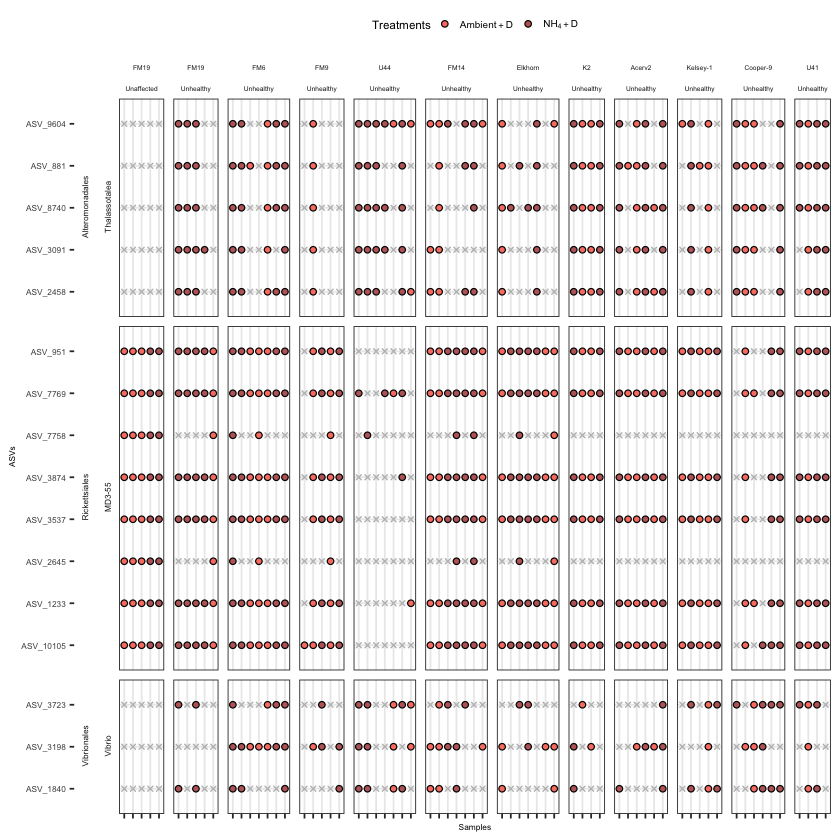

In [154]:

melt_ps_treat$Genotype = factor(melt_ps_treat$Genotype, levels = c("FM19", 
                                                                
                                        "FM6", "FM9", "U44",
                                        "FM14", "Elkhorn", "K2",
                                        "Acerv2", "Kelsey-1", "Cooper-9", "U41"
                                                                ))

melt_ps_treat$Combo = factor(melt_ps_treat$Combo, levels = c("Ambient_Pathogen", "NH4_Pathogen"
                                                                ))

lab1 <- c(
          expression(Ambient+D), 
         
          expression(NH[4]+D))

melt_ps_treat  %>%
#filter(Abundance !=0) %>%
filter(Combo!="Ambient_Placebo") %>%
filter(Combo!="NH4_Placebo") %>%
 mutate(
    across(where(is.character), ~ str_replace_all(.x, "o__", "")),
    across(where(is.character), ~ str_replace_all(.x, "g__", "")),
    zero_flag = Abundance == 0  # Flag zeros
  ) %>%
  ggplot(aes(x =sample_names, y = ASVs)) +
  
  # Layer 1: grey open circles for Abundance == 0
  geom_point(
    data = function(df) df %>% filter(zero_flag),
    colour = "grey", shape=4, size = 1, stroke = 0.6
  ) +

  # Layer 2: filled circles for Abundance > 0
  geom_point(
    data = function(df) df %>% filter(!zero_flag),
    aes(fill = Combo), shape=21
  ) +
scale_fill_manual("Treatments", values = c(  "salmon", "#bc6767"), labels= lab1) + 
theme_bw() +
  theme(
    strip.background = element_blank(),
    axis.title.x = element_text(size = 5),
    axis.title.y = element_text(size = 5),
    axis.text.x = element_blank(),
    axis.text.y = element_text(size = 5),
    strip.text.y.left = element_text(angle = 90, size = 5),
    strip.text.x = element_text(size = 4),
    legend.text = element_text(size = 6),
    legend.title = element_text(size = 7)
  ) +
 scale_x_discrete(drop = FALSE) +
  facet_grid(Order*Genus ~ Genotype*Outcome, space = "free", scales = "free", switch = "y") +

  guides(fill = guide_legend(keywidth = 0.5, keyheight = 0.35, ncol = 2)) +
#theme(axis.text.x = element_text(angle = 70, hjust = 1, size=5)) +
theme(legend.position="top") +
xlab("Samples")

ggsave("/Users/stephanie.rosales/Documents/omics_projects/Resitada/figures/dot_ANCOM.png", 
      width =6, height = 4, units = "in", dpi=300)

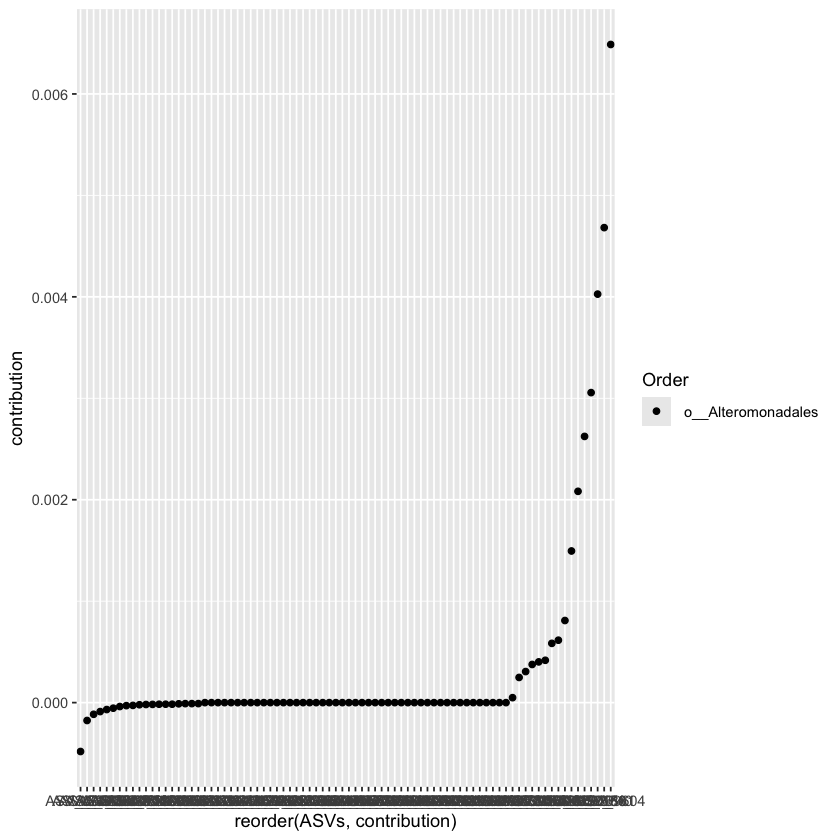

In [139]:
merged_data1 %>%
filter(Order == " o__Alteromonadales") %>%
distinct(variable_name, .keep_all = TRUE) %>%
ggplot(aes(x = reorder(ASVs, contribution), y = contribution, fill=Order)) +

geom_point()


In [140]:
tax_table_data=merged_data1 %>%
#filter(Order == " o__Alteromonadales") %>%
filter(variable_value != 0) %>%
#filter(contribution > -0.001 & contribution > 0.001) %>%
filter(contribution < -0.00045 | contribution > 0.01)  %>%
distinct(variable_name, .keep_all = TRUE)  %>%
as.data.frame()  %>%
column_to_rownames("variable_name")
tax_table_data <- as.matrix(tax_table_data)
head(tax_table_data)

dim(tax_table_data)

,variable,contribution,variable_value,sign,label,B,Kingdom,Phylum,Class,Order,Family,Genus,Species,ASVs
ac6820155a85d9cc15f8f62406e10e42,ac6820155a85d9cc15f8f62406e10e42 = 94,-0.0009522954,94,-1,Ranger,0,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rhodobacterales,f__Rhodobacteraceae,g__Shimia,NA,ASV_6816
e23bbf8f65f14f451c2071e477ed2b58,e23bbf8f65f14f451c2071e477ed2b58 = 104,-0.0014910131,104,-1,Ranger,0,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rhodobacterales,f__Rhodobacteraceae,g__Shimia,NA,ASV_8980
c4067f49ab443e01537a281084d61ee8,c4067f49ab443e01537a281084d61ee8 = 259,0.0100853864,259,1,Ranger,1,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rickettsiales,f__Fokiniaceae,g__MD3-55,NA,ASV_7758
7faad2d299566d181c7c321533a13692,X7faad2d299566d181c7c321533a13692 = 294,-0.0008496732,294,-1,Ranger,1,d__Bacteria,p__Bacteroidota,c__Bacteroidia,o__Flavobacteriales,f__Crocinitomicaceae,g__Fluviicola,NA,ASV_5096
af9929b8c403fc72989769d9876fc007,af9929b8c403fc72989769d9876fc007 = 409,-0.0011197674,409,-1,Ranger,5,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rickettsiales,f__Fokiniaceae,g__MD3-55,NA,ASV_6931
41861cce34e32070bc99d36682bf7540,X41861cce34e32070bc99d36682bf7540 = 366,0.0116433824,366,1,Ranger,6,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rickettsiales,f__Fokiniaceae,g__MD3-55,NA,ASV_2645


[1]  7 14

In [141]:

ps1= phyloseq(otu_table(ASVs, taxa_are_rows= T),
tax_table(tax_table_data), sample_data(meta), tree_file)
ps1

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 7 taxa and 280 samples ]
sample_data() Sample Data:       [ 280 samples by 58 sample variables ]
tax_table()   Taxonomy Table:    [ 7 taxa by 14 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 7 tips and 6 internal nodes ]

In [142]:
ps_Clipped1 =subset_samples(ps1, Type=="Clipped" & Pairs=="paired")

ps_Clipped1


phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 7 taxa and 145 samples ]
sample_data() Sample Data:       [ 145 samples by 58 sample variables ]
tax_table()   Taxonomy Table:    [ 7 taxa by 14 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 7 tips and 6 internal nodes ]

In [143]:
sum_Clipped1 = ps_Clipped1 %>%
  tax_glom(taxrank = "ASVs") %>%
  
  transform_sample_counts(function(x) {x/sum(x)} ) %>% # Transform to rel. abundance

  psmelt()
head(sum_Clipped1)

,OTU,Sample,Abundance,sample_names,featurecounts,Initial_sample_ID,Tag,start_date,event_date,Date_Collected,⋯,sign,label,B,Kingdom,Phylum,Class,Order,Family,Genus,ASVs
,<chr>,<chr>,<dbl>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
438,af9929b8c403fc72989769d9876fc007,N102-A012,1,N102-A012,13157,102,A012,2020-08-19,2020-11-05,5-Nov-20,⋯,-1,Ranger,5,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rickettsiales,f__Fokiniaceae,g__MD3-55,ASV_6931
439,af9929b8c403fc72989769d9876fc007,N106-A051,1,N106-A051,28128,106,A051,2020-08-19,2020-11-05,5-Nov-20,⋯,-1,Ranger,5,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rickettsiales,f__Fokiniaceae,g__MD3-55,ASV_6931
445,af9929b8c403fc72989769d9876fc007,N103-A028,1,N103-A028,38507,103,A028,2020-08-19,2020-11-05,5-Nov-20,⋯,-1,Ranger,5,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rickettsiales,f__Fokiniaceae,g__MD3-55,ASV_6931
446,af9929b8c403fc72989769d9876fc007,N107-162,1,N107-162,56431,107,162,2020-08-19,2020-11-05,5-Nov-20,⋯,-1,Ranger,5,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rickettsiales,f__Fokiniaceae,g__MD3-55,ASV_6931
452,af9929b8c403fc72989769d9876fc007,N104-276,1,N104-276,20691,104,276,2020-08-19,2020-11-05,5-Nov-20,⋯,-1,Ranger,5,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rickettsiales,f__Fokiniaceae,g__MD3-55,ASV_6931
453,af9929b8c403fc72989769d9876fc007,N108-A188,1,N108-A188,44424,108,A188,2020-08-19,2020-11-05,5-Nov-20,⋯,-1,Ranger,5,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rickettsiales,f__Fokiniaceae,g__MD3-55,ASV_6931


In [144]:
melt_ps_treat$Combo = factor(melt_ps_treat$Combo, levels = c("Ambient_Placebo",  "Ambient_Pathogen","NH4_Placebo", 
                                                             "NH4_Pathogen"))

melt_ps_treat$Genotype = factor(melt_ps_treat$Genotype, levels = c("FM19", 
                                                                
                                        "FM6", "FM9", "U44",
                                        "FM14", "Elkhorn", "K2",
                                        "Acerv2", "Kelsey-1", "Cooper-9", "U41"
                                                                ))
melt_ps_treat$Diseased <- factor(melt_ps_treat$Diseased, 
    levels = c("Placebo", "Pathogen"))

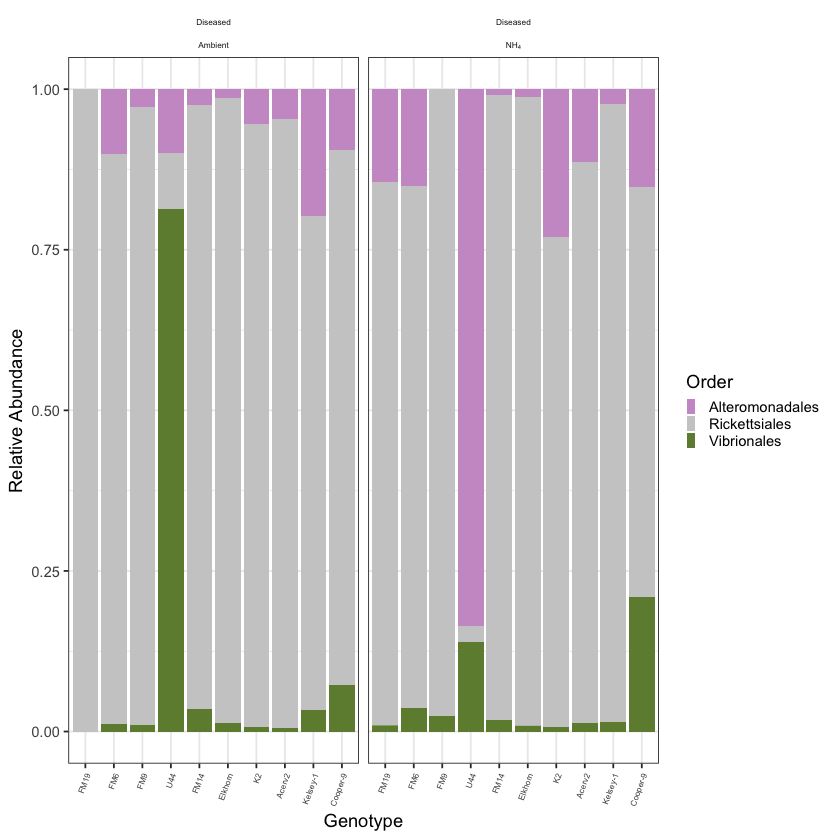

In [145]:

lab1 <- c(expression(Ambient+P),
          expression(Ambient+D), 
          expression(NH[4]+P),
          expression(NH[4]+D))

supp.labs <- as_labeller(c(Placebo="Placebo", Pathogen="Diseased"),
                           default = label_parsed)
my_labeller <- as_labeller(c(Ambient="Ambient", NH4="NH[4]"),
                           default = label_parsed)


melt_ps_treat %>%
#filter(Order != " o__Rickettsiales") %>%
filter(Genotype!="U41") %>%
filter(Abundance >0)  %>%
mutate_if(
                is.character, 
                stringr::str_replace_all, 
                pattern = "o__",
                replacement = "") %>%
#filter(contribution < -0.00045 | contribution > 0.01)  %>%
#filter(as.numeric(contribution < -0.045))  %>%
ggplot(
     aes(x=Genotype, y= Abundance, fill=Order)) +
geom_bar(stat = "identity",position="fill") +
#geom_point(aes(color=Order)) +
theme_bw() +

#scale_fill_manual("Treatments", values = c( "lightblue", "salmon", "#00688B", "#bc6767")) + 

theme(strip.background = element_rect(fill="white")) +
guides(fill = guide_legend(keywidth = 0.4, keyheight =.70, ncol=1)) +
#theme(panel.border=element_blank(), axis.line=element_line()) +
#facet_grid(Order~., space ="free", scales="free", switch = "y") +
#facet_grid(Order~Combo) +
facet_wrap(~Diseased*Nutrients, labeller = labeller(Nutrients=my_labeller,
                                                                    label_parsed, Diseased= supp.labs)) +
theme(strip.background = element_blank()) +
scale_fill_manual(values=c(
                           "#CD9BCD", "gray80", "darkolivegreen4", "#673770","#D14285", 
                           "#8569D5", "#5E738F",
                          "lightblue", "#CD9BCD")) +
# labs(fill = "Treatment") +
#theme(axis.title.x = element_text(size = 4)) +
#theme(legend.text =element_text(size=4)) +
#theme(legend.title = element_text(size=4)) +
#theme(legend.position="top") +
#theme(axis.title.y = element_text(size=4)) +
#theme(axis.text.y = element_text(size=4)) +

theme(axis.text.x = element_text(angle = 70, hjust = 1, size=5)) +
theme(strip.text.x = element_text(size = 5)) +
ylab("Relative Abundance") +
xlab("Genotype") 

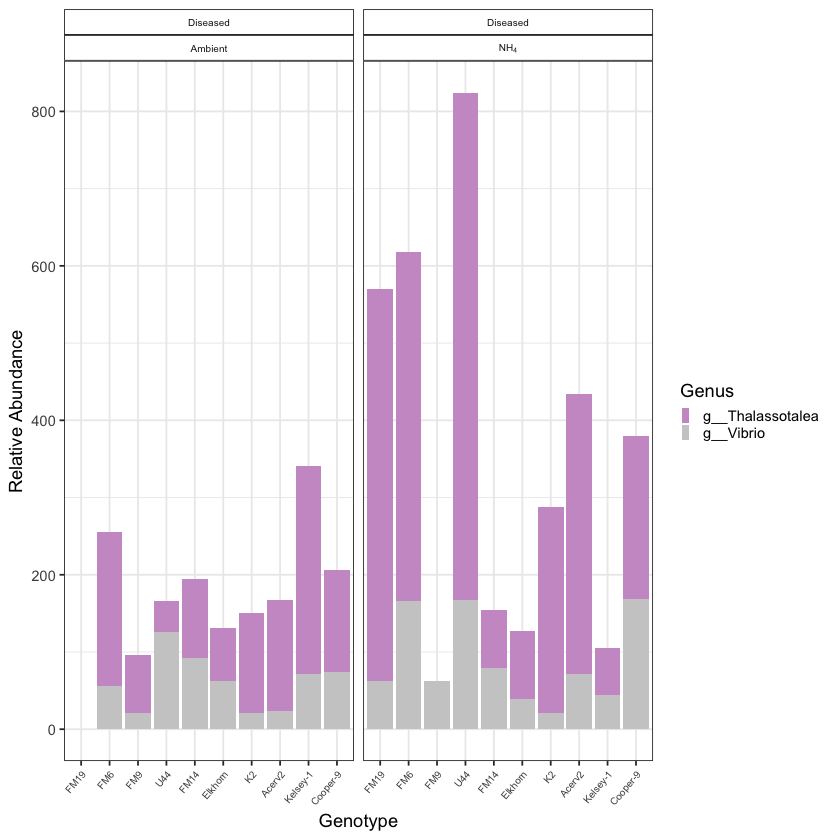

In [146]:
melt_ps_treat%>%
filter(Order != " o__Rickettsiales") %>%
filter(Genotype!="U41") %>%
filter(Abundance >0)  %>%
mutate_if(
                is.character, 
                stringr::str_replace_all, 
                pattern = "o__",
                replacement = "") %>%
#filter(contribution < -0.00045 | contribution > 0.01)  %>%
#filter(as.numeric(contribution < -0.045))  %>%
ggplot(
     aes(x=Genotype, y= sqrt(Abundance), fill=Genus)) +
geom_bar(stat = "identity",position="stack") +
#geom_point(aes(color=Order)) +
theme_bw() +

#scale_fill_manual("Treatments", values = c( "lightblue", "salmon", "#00688B", "#bc6767")) + 

theme(strip.background = element_rect(fill="white")) +
guides(fill = guide_legend(keywidth = 0.4, keyheight =.70, ncol=1)) +
#theme(panel.border=element_blank(), axis.line=element_line()) +
#facet_grid(Order~., space ="free", scales="free", switch = "y") +
#facet_grid(Order~Combo) +
facet_wrap(~Diseased*Nutrients, labeller = labeller(Nutrients=my_labeller,
                                                                    label_parsed, Diseased= supp.labs)) +
#theme(strip.background = element_blank()) +
scale_fill_manual(values=c("#CD9BCD", "gray80", "darkolivegreen4", "#673770","#D14285", 
                           "#8569D5", "#5E738F",
                          "lightblue", "#CD9BCD", "#3CB371","tan","#5F7FC7", "orange","#ADFF2F", 
                           "#CD9BCD", "gray80", "darkolivegreen4", "#673770","#D14285", 
                           "#8569D5", "#5E738F","#AD6F3B",
                          "lightblue", "salmon","Navy", "#CBD588",
                           "lightblue4", "ivory4", "darkorchid", "palevioletred1",
                           "#DA5724","#CD9BCD","#8fa746","#404b1f","#8FBC8F", 
                            "khaki1","#41636f","#00AEEF","#8bbfd2","brown","#AD6F3B","tan",
                           "#90EE90","#8fa746","lightblue4", "ivory4", "darkorchid", "palevioletred1",
                           "#DA5724","#CD9BCD","#8fa746","#404b1f","#8FBC8F",
                           "#3CB371","tan","#5F7FC7", "orange","#ADFF2F", 
                           "#CD9BCD", "gray80", "darkolivegreen4", "#673770","#D14285" 
                          )) +
# labs(fill = "Treatment") +
#theme(axis.title.x = element_text(size = 4)) +
#theme(legend.text =element_text(size=4)) +
#theme(legend.title = element_text(size=4)) +
#theme(legend.position="top") +
#theme(axis.title.y = element_text(size=4)) +
#theme(axis.text.y = element_text(size=4)) +

theme(axis.text.x = element_text(angle = 50, hjust = 1, size=6)) +
theme(strip.text.x = element_text(size = 6)) +
ylab("Relative Abundance") +
xlab("Genotype") 


#ggsave("/Users/stephanie.rosales/Documents/omics_projects/Resitada/figures/RF_SURV.png", 
 #     width = 4.4, height = 4.4, units = "in", dpi=300)

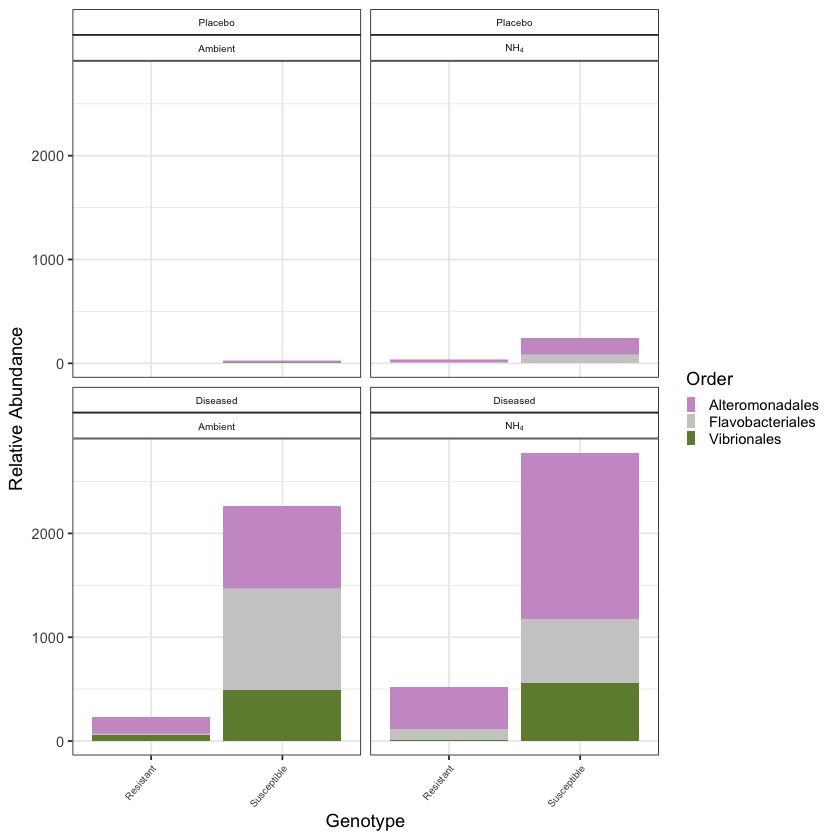

In [155]:
melt_ps_treat %>%
filter(Order != " o__Rickettsiales") %>%
filter(Genotype!="U41") %>%
filter(Abundance >0)  %>%
mutate_if(
                is.character, 
                stringr::str_replace_all, 
                pattern = "o__",
                replacement = "") %>%
#filter(contribution < -0.00045 | contribution > 0.01)  %>%
#filter(as.numeric(contribution < -0.045))  %>%
ggplot(
     aes(x=Disease_Susceptibility, y= sqrt(Abundance), fill=Order)) +
geom_bar(stat = "identity",position="stack") +
#geom_point(aes(color=Order)) +
theme_bw() +

#scale_fill_manual("Treatments", values = c( "lightblue", "salmon", "#00688B", "#bc6767")) + 

theme(strip.background = element_rect(fill="white")) +
guides(fill = guide_legend(keywidth = 0.4, keyheight =.70, ncol=1)) +
#theme(panel.border=element_blank(), axis.line=element_line()) +
#facet_grid(Order~., space ="free", scales="free", switch = "y") +
#facet_grid(Order~Combo) +
facet_wrap(~Diseased*Nutrients, labeller = labeller(Nutrients=my_labeller,
                                                                    label_parsed, Diseased= supp.labs)) +
#theme(strip.background = element_blank()) +
scale_fill_manual(values=c("#CD9BCD", "gray80", "darkolivegreen4", "#673770","#D14285", 
                           "#8569D5", "#5E738F",
                          "lightblue", "#CD9BCD", "#3CB371","tan","#5F7FC7", "orange","#ADFF2F", 
                           "#CD9BCD", "gray80", "darkolivegreen4", "#673770","#D14285", 
                           "#8569D5", "#5E738F","#AD6F3B",
                          "lightblue", "salmon","Navy", "#CBD588",
                           "lightblue4", "ivory4", "darkorchid", "palevioletred1",
                           "#DA5724","#CD9BCD","#8fa746","#404b1f","#8FBC8F", 
                            "khaki1","#41636f","#00AEEF","#8bbfd2","brown","#AD6F3B","tan",
                           "#90EE90","#8fa746","lightblue4", "ivory4", "darkorchid", "palevioletred1",
                           "#DA5724","#CD9BCD","#8fa746","#404b1f","#8FBC8F",
                           "#3CB371","tan","#5F7FC7", "orange","#ADFF2F", 
                           "#CD9BCD", "gray80", "darkolivegreen4", "#673770","#D14285" 
                          )) +
# labs(fill = "Treatment") +
#theme(axis.title.x = element_text(size = 4)) +
#theme(legend.text =element_text(size=4)) +
#theme(legend.title = element_text(size=4)) +
#theme(legend.position="top") +
#theme(axis.title.y = element_text(size=4)) +
#theme(axis.text.y = element_text(size=4)) +

theme(axis.text.x = element_text(angle = 50, hjust = 1, size=6)) +
theme(strip.text.x = element_text(size = 6)) +
ylab("Relative Abundance") +
xlab("Genotype") 

In [156]:
sum_Clipped1 %>%
filter(Order == " o__Rickettsiales") %>%
filter(Genotype!="U41") %>%
filter(Abundance >0)  %>%
mutate_if(
                is.character, 
                stringr::str_replace_all, 
                pattern = "o__",
                replacement = "") %>%
#filter(contribution < -0.00045 | contribution > 0.01)  %>%
#filter(as.numeric(contribution < -0.045))  %>%
ggplot(
     aes(x=ASVs, y= Abundance, fill=Genotype)) +
geom_bar(stat = "identity",position="stack") +
#geom_point(aes(color=Order)) +
theme_bw() +

#scale_fill_manual("Treatments", values = c( "lightblue", "salmon", "#00688B", "#bc6767")) + 

theme(strip.background = element_rect(fill="white")) +
guides(fill = guide_legend(keywidth = 0.4, keyheight =.70, ncol=1)) +
#theme(panel.border=element_blank(), axis.line=element_line()) +
#facet_grid(Order~., space ="free", scales="free", switch = "y") +
#facet_grid(Order~Combo) +
facet_wrap(~Diseased*Nutrients, labeller = labeller(Nutrients=my_labeller,
                                                                    label_parsed, Diseased= supp.labs)) +
theme(strip.background = element_blank()) +
scale_fill_manual(values=c("#3CB371","tan","#5F7FC7", "orange","#ADFF2F", 
                           "#CD9BCD", "gray80", "darkolivegreen4", "#673770","#D14285", 
                           "#8569D5", "#5E738F","#AD6F3B",
                          "lightblue", "salmon","Navy", "#CBD588",
                           "lightblue4", "ivory4", "darkorchid", "palevioletred1",
                           "#DA5724","#CD9BCD","#8fa746","#404b1f","#8FBC8F", 
                            "khaki1","#41636f","#00AEEF","#8bbfd2","brown","#AD6F3B","tan",
                           "#90EE90","#8fa746","lightblue4", "ivory4", "darkorchid", "palevioletred1",
                           "#DA5724","#CD9BCD","#8fa746","#404b1f","#8FBC8F",
                           "#3CB371","tan","#5F7FC7", "orange","#ADFF2F", 
                           "#CD9BCD", "gray80", "darkolivegreen4", "#673770","#D14285" 
                          )) +
# labs(fill = "Treatment") +
#theme(axis.title.x = element_text(size = 4)) +
#theme(legend.text =element_text(size=4)) +
#theme(legend.title = element_text(size=4)) +
#theme(legend.position="top") +
#theme(axis.title.y = element_text(size=4)) +
#theme(axis.text.y = element_text(size=4)) +

theme(axis.text.x = element_text(angle = 30, hjust = 1, size=7)) +
theme(strip.text.x = element_text(size = 6)) +
ylab("Relative Abundance") +
xlab("Order") 

ERROR while rich displaying an object: Error in `combine_vars()`:
! Faceting variables must have at least one value.

Traceback:
1. sapply(x, f, simplify = simplify)
2. lapply(X = X, FUN = FUN, ...)
3. FUN(X[[i]], ...)
4. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
5. tryCatchList(expr, classes, parentenv, handlers)
6. tryCatchOne(expr, names, parentenv, handlers[[1L]])
7. doTryCatch(return(expr), name, parentenv, handler)
8. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 .

In [157]:
dim(melt_ps_treat)

[1] 1350   69

In [65]:
library('ggpmisc')

Loading required package: ggpp

Registered S3 methods overwritten by 'ggpp':
  method                  from   
  heightDetails.titleGrob ggplot2
  widthDetails.titleGrob  ggplot2


Attaching package: ‘ggpp’


The following object is masked from ‘package:ggplot2’:

    annotate




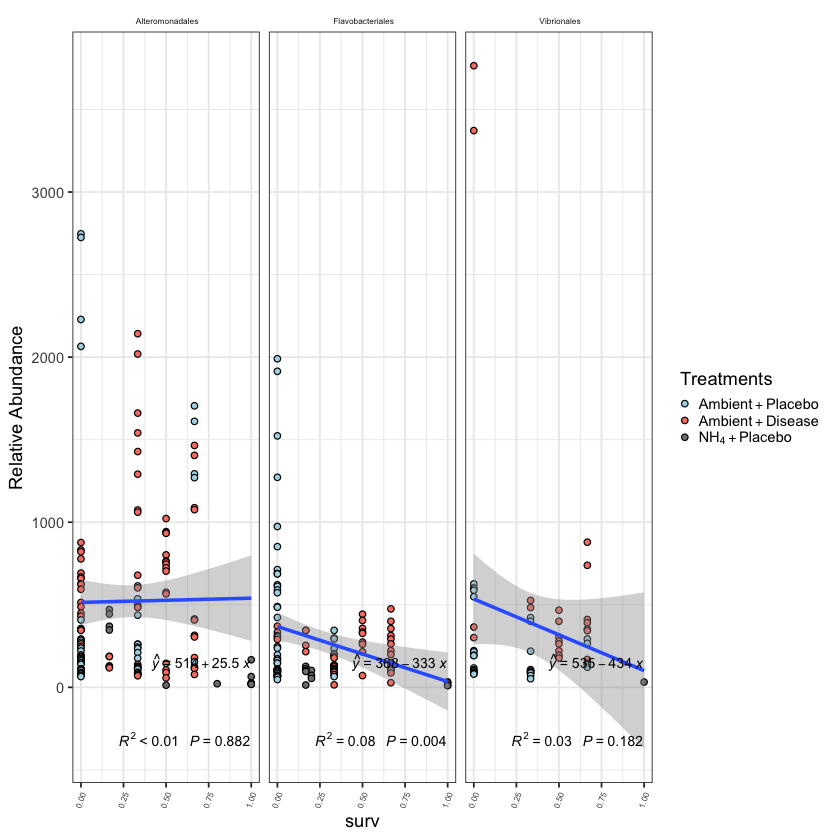

In [158]:

melt_ps_treat$Combo <- factor(melt_ps_treat$Combo, 
    levels = c("Ambient_Placebo", "Ambient_Pathogen", "NH4_Placebo", "NH4_Pathogen"))

lab1 <- c(expression(Ambient+Placebo),
          expression(Ambient+Disease), 
          expression(NH[4]+Placebo),
          expression(NH[4]+Disease))

melt_ps_treat %>%
#filter(ASVs == "ASV_7758") %>%
#filter(Genotype!="U41") %>%
filter(Genotype!="U44") %>%
filter(Abundance >0)  %>%
#filter(Abundance !=1)  %>%
mutate_if(
                is.character, 
                stringr::str_replace_all, 
                pattern = "o__",
                replacement = "") %>%
#filter(contribution < -0.00045 | contribution > 0.01)  %>%
#filter(as.numeric(contribution < -0.045))  %>%
ggplot(
     aes(x=surv, y= Abundance)) +
#geom_bar(stat = "identity",position="fill") +
geom_point(aes(fill=Combo), pch=21) +
geom_smooth(method = lm, formula = y ~ x) +

scale_fill_manual("Treatments", values = c("lightblue", "salmon", "#00688B", "#bc6767"), labels= lab1) + 

 stat_poly_eq(formula = y ~ x,
                eq.with.lhs = "italic(hat(y))~`=`~",
                aes(label = paste( ..rr.label.., ..p.value.label.., sep = "~~~")), 
                parse = TRUE, label.y = "bottom", label.x = "right", color="black",
             rr.digits = 2, , size = 3) +

 stat_poly_eq(aes(label = paste(..eq.label.., sep = "~~~")), 
               label.y = 0.15,
               eq.with.lhs = "italic(hat(y))~`=`~",
               eq.x.rhs = "~italic(x)",
               formula = y ~ x, parse = TRUE, size = 3,
               label.x = "right", color="black") +



theme_bw() +

#scale_fill_manual("Treatments", values = c( "lightblue", "salmon", "#00688B", "#bc6767")) + 

theme(strip.background = element_rect(fill="white")) +
guides(fill = guide_legend(keywidth = 0.4, keyheight =.70, ncol=1)) +
#theme(panel.border=element_blank(), axis.line=element_line()) +
#facet_grid(Order~., space ="free", scales="free", switch = "y") +
#facet_grid(Order~Combo) +
facet_wrap(.~Order) +
theme(strip.background = element_blank()) +
#scale_color_manual("Treatments", values = c( "#AA4A74", "#469B53" ,"#454B1B", "#AA4A74"), labels= lab1) + 

#scale_fill_manual(values=c(
 #                          "#CD9BCD", "darkolivegreen4", "#673770","#D14285", 
  #                         "#8569D5", "#5E738F",
   #                       "lightblue", "#CD9BCD")) +
# labs(fill = "Treatment") +
#theme(axis.title.x = element_text(size = 4)) +
#theme(legend.text =element_text(size=4)) +
#theme(legend.title = element_text(size=4)) +
#theme(legend.position="top") +
#theme(axis.title.y = element_text(size=4)) +
#theme(axis.text.y = element_text(size=4)) +

theme(axis.text.x = element_text(angle = 70, hjust = 1, size=5)) +
theme(strip.text.x = element_text(size = 5)) +
ylab("Relative Abundance") 

In [159]:
melt_ps_treat %>%
filter(Order != " o__Rickettsiales") %>%
filter(Genotype!="U41") %>%
filter(Abundance >0)  %>%
#filter(contribution < -0.00045 | contribution > 0.01)  %>%
#filter(as.numeric(contribution < -0.045))  %>%
ggplot(
     aes(x=reorder(Genotype, as.numeric(contribution)), y= as.numeric(contribution), fill=Order)) +
#geom_bar(stat = "identity",position="stack") +
geom_point(aes(color=Order, size=Abundance)) +
theme_bw() +

#scale_fill_manual("Treatments", values = c( "lightblue", "salmon", "#00688B", "#bc6767")) + 

theme(strip.background = element_rect(fill="white")) +
guides(fill = guide_legend(keywidth = 0.4, keyheight =.70, ncol=1)) +
#theme(panel.border=element_blank(), axis.line=element_line()) +
#facet_grid(Order~., space ="free", scales="free", switch = "y") +
#facet_grid(Order~Combo) +
facet_wrap(~Combo) +
theme(strip.background = element_blank()) +
# labs(fill = "Treatment") +
#theme(axis.title.x = element_text(size = 4)) +
#theme(legend.text =element_text(size=4)) +
#theme(legend.title = element_text(size=4)) +
#theme(legend.position="top") +
#theme(axis.title.y = element_text(size=4)) +
#theme(axis.text.y = element_text(size=4)) +

theme(axis.text.x = element_text(angle = 70, hjust = 1, size=5)) +
theme(strip.text.x = element_text(size = 5)) +
ylab("Relative Abundance") +
xlab("Genotype") 

ERROR while rich displaying an object: Error in `geom_point()`:
! Problem while computing aesthetics.
ℹ Error occurred in the 1st layer.
Caused by error:
! object 'contribution' not found

Traceback:
1. sapply(x, f, simplify = simplify)
2. lapply(X = X, FUN = FUN, ...)
3. FUN(X[[i]], ...)
4. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
5. tryCatchList(expr, classes, parentenv, handlers)
6. tryCatchOne(expr, names, parentenv, handlers[[1L]])
7. doTryCatch(return(expr), name, parentenv, handler)
8. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr

In [72]:
sum_Clipped1 %>%
filter(Order != " o__Rickettsiales") %>%
filter(Genotype!="U41") %>%
filter(Abundance >0)  %>%
#filter(contribution < -0.00045 | contribution > 0.01)  %>%
#filter(as.numeric(contribution < -0.045))  %>%
ggplot(
ggplot(aes(x=Abundance, y=as.numeric(contribution))) +
#geom_bar(stat = "identity",position="stack") +
geom_point(color=Genotype) +
theme_bw() +

#scale_fill_manual("Treatments", values = c( "lightblue", "salmon", "#00688B", "#bc6767")) + 

theme(strip.background = element_rect(fill="white")) +
guides(fill = guide_legend(keywidth = 0.4, keyheight =.70, ncol=1)) +
#theme(panel.border=element_blank(), axis.line=element_line()) +
#facet_grid(Order~., space ="free", scales="free", switch = "y") +
#facet_grid(Order~Combo) +
facet_wrap(~Combo) +
theme(strip.background = element_blank()) +
# labs(fill = "Treatment") +
#theme(axis.title.x = element_text(size = 4)) +
#theme(legend.text =element_text(size=4)) +
#theme(legend.title = element_text(size=4)) +
#theme(legend.position="top") +
#theme(axis.title.y = element_text(size=4)) +
#theme(axis.text.y = element_text(size=4)) +

theme(axis.text.x = element_text(angle = 70, hjust = 1, size=5)) +
theme(strip.text.x = element_text(size = 5)) +
ylab("Relative Abundance") +
xlab("Genotype") 

ERROR: Error in parse(text = input): <text>:34:0: unexpected end of input
32: ylab("Relative Abundance") +
33: xlab("Genotype") 
   ^


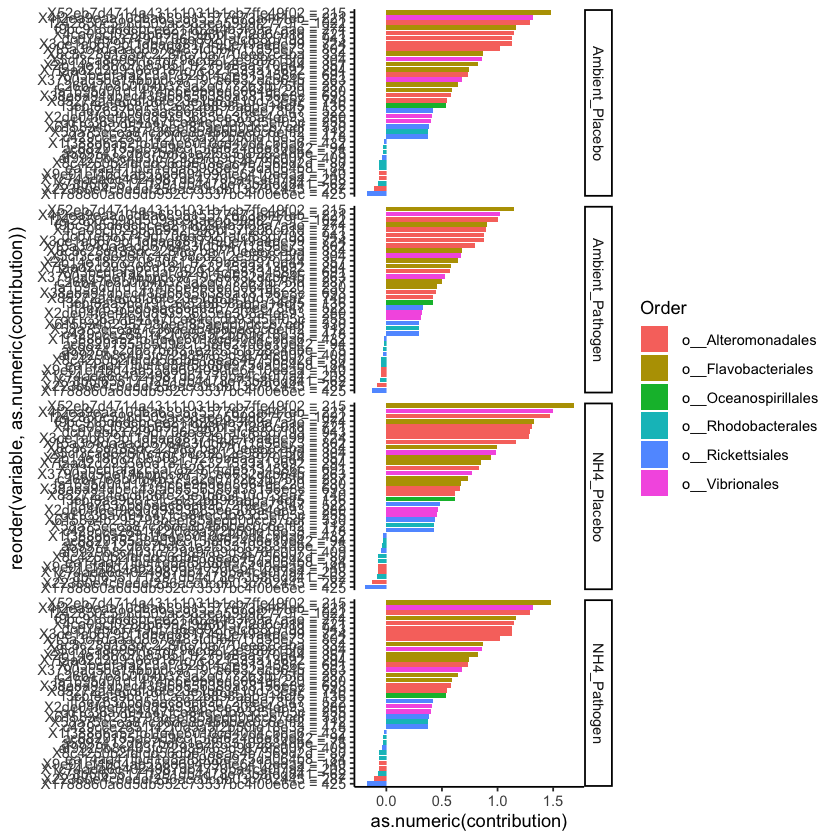

In [73]:
sum_Clipped1 %>%
filter(Genotype!="U41") %>%
#filter(variable_value != 0) %>%
#filter(contribution > -0.001 & contribution > 0.001) %>%
#filter(contribution < -0.00045 | contribution > 0.01)  %>%
ggplot(aes(x = reorder(variable, as.numeric(contribution)), y = as.numeric(contribution), fill=Order)) +
  
geom_bar(stat = "identity") +
facet_grid(Combo~.) +

  coord_flip() +
theme_classic()

In [ ]:
head(merged_data)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


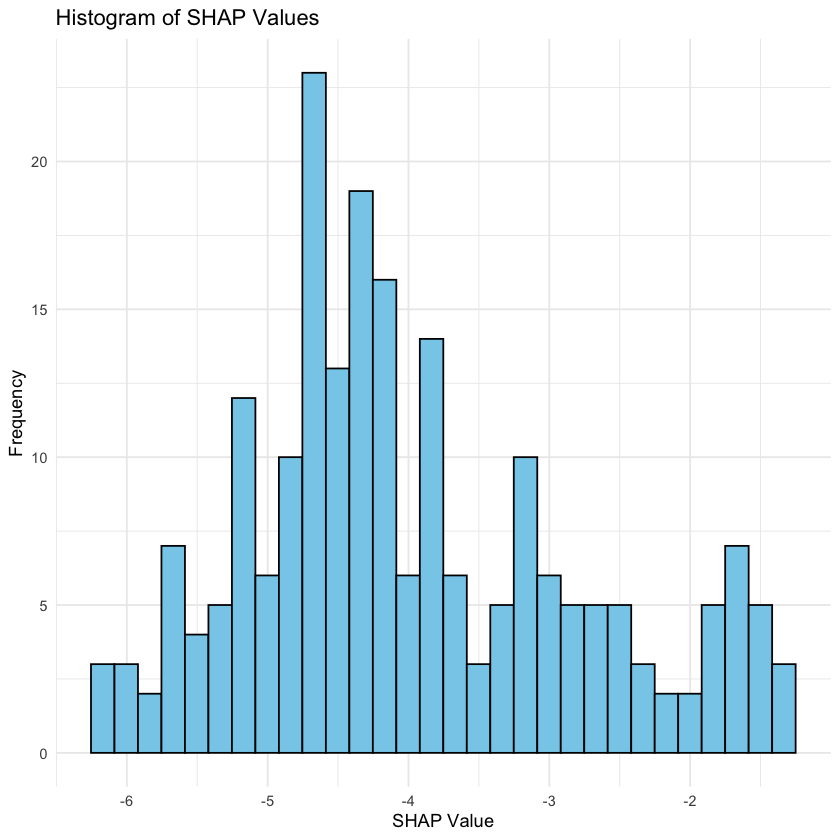

In [160]:
# Plot histogram
merged_data1 %>%
distinct(variable_name, .keep_all = TRUE)  %>%
filter(contribution >0)  %>%
ggplot(aes(x = log10(contribution))) +
  geom_histogram(color = "black", fill = "skyblue") +
  labs(title = "Histogram of SHAP Values", x = "SHAP Value", y = "Frequency") +
  theme_minimal()

In [161]:
library('broom')

In [162]:
head(merged_data)

,variable,contribution,variable_name,variable_value,sign,label,B,Kingdom,Phylum,Class,Order,Family,Genus,Species,ASVs
,<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,a059c84c052e0f8290ff18391e4fef39 = 16,0.000000e+00,a059c84c052e0f8290ff18391e4fef39,16,0,Ranger,0,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Cellvibrionales,f__Cellvibrionaceae,g__Aestuariicella,s__uncultured_bacterium,ASV_6385
2,a0885a09f9af5b6ad26689de947cbd88 = 0,1.646091e-06,a0885a09f9af5b6ad26689de947cbd88,0,1,Ranger,0,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Cellvibrionales,f__Halieaceae,NA,NA,ASV_6392
3,a0e1ca73da87e4c1e30becef7a42de10 = 0,0.000000e+00,a0e1ca73da87e4c1e30becef7a42de10,0,0,Ranger,0,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rhodobacterales,f__Rhodobacteraceae,NA,NA,ASV_6407
4,a0fc8d8c3c84ed90adfdb3c3828a3341 = 0,-1.232099e-04,a0fc8d8c3c84ed90adfdb3c3828a3341,0,-1,Ranger,0,d__Bacteria,p__Verrucomicrobiota,c__Verrucomicrobiae,o__Verrucomicrobiales,f__Rubritaleaceae,g__Rubritalea,s__Rubritalea_tangerina,ASV_6413
5,a14b7162edeb7a30ddb2a46656539857 = 0,-1.402986e-04,a14b7162edeb7a30ddb2a46656539857,0,-1,Ranger,0,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rhodobacterales,f__Rhodobacteraceae,NA,NA,ASV_6427
6,a1718222b00e5737c311981c7cda898c = 0,-1.975309e-05,a1718222b00e5737c311981c7cda898c,0,-1,Ranger,0,d__Bacteria,p__Bdellovibrionota,c__Oligoflexia,o__Oligoflexales,f__Oligoflexales,g__Pseudobacteriovorax,s__uncultured_bacterium,ASV_6434


In [77]:
merged_data_fill=merged_data %>%
distinct(variable_name, .keep_all = TRUE)  %>%
filter(contribution >0)
#unite("CAT", variable_name:contribution)
head(merged_data_fill)

,variable,contribution,variable_name,variable_value,sign,label,B,Kingdom,Phylum,Class,Order,Family,Genus,Species,ASVs
,<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,a1a69a28a6f49e945172ee67e0f33028 = 0,7.111111e-06,a1a69a28a6f49e945172ee67e0f33028,0,1,Ranger,0,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rhodobacterales,f__Rhodobacteraceae,NA,NA,ASV_6439
2,a2864b81d6dcb547070d7a09ee012695 = 0,1.185185e-05,a2864b81d6dcb547070d7a09ee012695,0,1,Ranger,0,d__Bacteria,p__Planctomycetota,c__Planctomycetes,o__Planctomycetales,f__Rubinisphaeraceae,g__Fuerstia,NA,ASV_6472
3,a3c29bcb6997cfe572a474e58291af1d = 0,9.583117e-04,a3c29bcb6997cfe572a474e58291af1d,0,1,Ranger,0,d__Bacteria,p__Spirochaetota,c__Spirochaetia,o__Spirochaetales,f__Spirochaetaceae,g__Spirochaeta_2,NA,ASV_6512
4,a5997412dbc7bdf31e2f533103884dbe = 75,1.491373e-03,a5997412dbc7bdf31e2f533103884dbe,75,1,Ranger,0,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rhodobacterales,f__Rhodobacteraceae,g__Shimia,NA,ASV_6577
5,a8e8ac62e30284db378ad48fa9bd97ec = 0,3.555556e-05,a8e8ac62e30284db378ad48fa9bd97ec,0,1,Ranger,0,d__Bacteria,p__Spirochaetota,c__Spirochaetia,o__Spirochaetales,f__Spirochaetaceae,g__Spirochaeta_2,s__uncultured_Spirochaetes,ASV_6693
6,a96071ca5549311b47e0fdd11146635a = 0,1.823362e-06,a96071ca5549311b47e0fdd11146635a,0,1,Ranger,0,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rhodobacterales,f__Rhodobacteraceae,NA,NA,ASV_6708


In [78]:
library('brms')

ERROR: Error in library("brms"): there is no package called ‘brms’


In [ ]:


# Define priors
prior <- c(
  prior(normal(0, 10000), class = "b"),
  prior(cauchy(0, 2), class = "sigma")
)

# Fit model with increased treedepth, iterations, and priors
brms_model <- brm(
  contribution ~ sign,
  data = merged_data_fill,
  family = gaussian(),
  prior = prior,
  iter = 6000,                 # Increase iterations
  control = list(max_treedepth = 15),  # Increase max_treedepth
  chains = 2,
  cores = 2
)


In [ ]:
summary(brms_model)

In [ ]:
par(mfrow = c(2, 2))
plot(model)